In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

C:\Users\User\AppData\Local\Temp\ipykernel_417992\1118364967.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  specific_humidity      slp  wet_bulb_temperature  temperatures  \
0       6678              12.82  1016.20                 18.08         20.84   
1       6678              12.33  1017.48                 17.71         20.69   
2       6678              12.14  1018.26                 17.29         20.47   
3       6678              11.90  1018.41                 17.20         20.30   
4       6678              12.75  1017.92                 17.75         20.46   
..       ...                ...      ...                   ...           ...   
643     8000               5.15  1016.94                  7.64         13.02   
644     8000               5.24  1016.16                  7.88         13.47   
645     8000               5.36  1017.90                  7.13         11.84   
646     8000               5.43  1016.17                  7.66         12.86   
647     8000               5.32  1015.12                  8.11         13.58   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 243)
(2, 243)


[I 2025-06-07 07:17:25,258] A new study created in memory with name: no-name-f78b9235-f3eb-41fc-b6fa-3a8bac7eff14
[I 2025-06-07 07:19:01,413] Trial 0 finished with value: 0.09912821501493455 and parameters: {'lr': 0.6275076932223186, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.35481226196803994}. Best is trial 0 with value: 0.09912821501493455.


Cross Validation Accuracies:
[0.10530322045087814, 0.12897783517837524, 0.07742753624916077, 0.13076873123645782, 0.05316375195980072]
Mean Cross Validation Accuracy:
0.09912821501493455
Standard Deviation of Cross Validation Accuracy:
0.03004631127324006


[I 2025-06-07 07:20:53,567] Trial 1 finished with value: 6.8006988048553465 and parameters: {'lr': 0.5049261003194517, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4921614571910129}. Best is trial 0 with value: 0.09912821501493455.


Cross Validation Accuracies:
[7.771005153656006, 3.692298173904419, 7.777169704437256, 8.365581512451172, 6.397439479827881]
Mean Cross Validation Accuracy:
6.8006988048553465
Standard Deviation of Cross Validation Accuracy:
1.6833668811345521


[I 2025-06-07 07:22:57,514] Trial 2 finished with value: 0.08277424499392509 and parameters: {'lr': 0.09468862730110439, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.30318571224381896}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.06907238066196442, 0.12134446948766708, 0.057663511484861374, 0.09161197394132614, 0.07417888939380646]
Mean Cross Validation Accuracy:
0.08277424499392509
Standard Deviation of Cross Validation Accuracy:
0.022171774091725487


[I 2025-06-07 07:25:03,982] Trial 3 finished with value: 0.09288059398531914 and parameters: {'lr': 0.0012235230666344018, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15995822631987855}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.050750408321619034, 0.12623228132724762, 0.05297069996595383, 0.14133693277835846, 0.09311264753341675]
Mean Cross Validation Accuracy:
0.09288059398531914
Standard Deviation of Cross Validation Accuracy:
0.036954452644636905


[I 2025-06-07 07:26:35,195] Trial 4 finished with value: 0.8955928802490234 and parameters: {'lr': 0.19582466511479124, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.46151636757741366}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.8304815888404846, 0.5513913035392761, 0.7095673084259033, 1.6785436868667603, 0.7079805135726929]
Mean Cross Validation Accuracy:
0.8955928802490234
Standard Deviation of Cross Validation Accuracy:
0.40138014020719587


[I 2025-06-07 07:28:40,069] Trial 5 finished with value: 0.12860945016145706 and parameters: {'lr': 0.08843576296148832, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.41439428369377107}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.14773216843605042, 0.1209203451871872, 0.11087080091238022, 0.16802561283111572, 0.09549832344055176]
Mean Cross Validation Accuracy:
0.12860945016145706
Standard Deviation of Cross Validation Accuracy:
0.02603628606013317


[I 2025-06-07 07:30:41,631] Trial 6 finished with value: 0.10231842920184135 and parameters: {'lr': 0.0048542109993764656, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3350313712065822}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.057331863790750504, 0.14168402552604675, 0.05380769073963165, 0.17388589680194855, 0.08488266915082932]
Mean Cross Validation Accuracy:
0.10231842920184135
Standard Deviation of Cross Validation Accuracy:
0.047650060094074215


[I 2025-06-07 07:35:22,260] Trial 7 finished with value: 6.1676064252853395 and parameters: {'lr': 0.0857855574698947, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.16121543765800495}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[9.530529975891113, 1.7519892454147339, 7.89527702331543, 4.544305324554443, 7.115930557250977]
Mean Cross Validation Accuracy:
6.1676064252853395
Standard Deviation of Cross Validation Accuracy:
2.73225916430296


[I 2025-06-07 07:40:26,051] Trial 8 finished with value: 0.12016676589846612 and parameters: {'lr': 0.0031529762589865003, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3030115791393063}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.046712856739759445, 0.13686199486255646, 0.11638043820858002, 0.17466750741004944, 0.1262110322713852]
Mean Cross Validation Accuracy:
0.12016676589846612
Standard Deviation of Cross Validation Accuracy:
0.041702296578326116


[I 2025-06-07 07:45:09,208] Trial 9 finished with value: 0.11439894922077656 and parameters: {'lr': 0.2368478129681789, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2765084161807134}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.03374641388654709, 0.1805233210325241, 0.15346473455429077, 0.17515094578266144, 0.029109330847859383]
Mean Cross Validation Accuracy:
0.11439894922077656
Standard Deviation of Cross Validation Accuracy:
0.06836449908470726


[I 2025-06-07 07:50:56,526] Trial 10 finished with value: 0.0910203993320465 and parameters: {'lr': 0.022122855118398056, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23177380562815747}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.1019086241722107, 0.12713377177715302, 0.05102735757827759, 0.12710179388523102, 0.04793044924736023]
Mean Cross Validation Accuracy:
0.0910203993320465
Standard Deviation of Cross Validation Accuracy:
0.035159019694670036


[I 2025-06-07 07:57:23,972] Trial 11 finished with value: 0.0967830017209053 and parameters: {'lr': 0.01766638628848029, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23156941819358795}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.10452885180711746, 0.12848438322544098, 0.07224898785352707, 0.12986944615840912, 0.04878333956003189]
Mean Cross Validation Accuracy:
0.0967830017209053
Standard Deviation of Cross Validation Accuracy:
0.03182946431334623


[I 2025-06-07 08:03:30,238] Trial 12 finished with value: 0.09560797810554504 and parameters: {'lr': 0.020635554545134743, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22874637113826662}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.10602885484695435, 0.12787790596485138, 0.06609774380922318, 0.12707623839378357, 0.05095914751291275]
Mean Cross Validation Accuracy:
0.09560797810554504
Standard Deviation of Cross Validation Accuracy:
0.03163721328810804


[I 2025-06-07 08:09:09,334] Trial 13 finished with value: 0.11128567866981029 and parameters: {'lr': 0.049088570263892746, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10561086534458425}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.16513805091381073, 0.16386812925338745, 0.1352672427892685, 0.0791219174861908, 0.013033052906394005]
Mean Cross Validation Accuracy:
0.11128567866981029
Standard Deviation of Cross Validation Accuracy:
0.05818624154588308


[I 2025-06-07 08:14:26,321] Trial 14 finished with value: 0.20513724833726882 and parameters: {'lr': 0.010055051334813795, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24305322523882877}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.2898402214050293, 0.17523565888404846, 0.2357051521539688, 0.08610332757234573, 0.23880188167095184]
Mean Cross Validation Accuracy:
0.20513724833726882
Standard Deviation of Cross Validation Accuracy:
0.0697215565980207


[I 2025-06-07 08:19:12,616] Trial 15 finished with value: 0.10151771456003189 and parameters: {'lr': 0.0425253635274632, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3811970274624116}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.1051618680357933, 0.13014352321624756, 0.07599444687366486, 0.1485145390033722, 0.04777419567108154]
Mean Cross Validation Accuracy:
0.10151771456003189
Standard Deviation of Cross Validation Accuracy:
0.036280080759260265


[I 2025-06-07 08:23:53,562] Trial 16 finished with value: 0.0963733159005642 and parameters: {'lr': 0.0072840305342069716, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1838670984966557}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.0991252064704895, 0.12891319394111633, 0.07430501282215118, 0.1288563311100006, 0.05066683515906334]
Mean Cross Validation Accuracy:
0.0963733159005642
Standard Deviation of Cross Validation Accuracy:
0.030651770664133614


[I 2025-06-07 08:28:35,159] Trial 17 finished with value: 0.08584569916129112 and parameters: {'lr': 0.19510464206931352, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2829289429364601}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.044182926416397095, 0.12415056675672531, 0.0570392869412899, 0.08464117348194122, 0.11921454221010208]
Mean Cross Validation Accuracy:
0.08584569916129112
Standard Deviation of Cross Validation Accuracy:
0.03208672456893492


[I 2025-06-07 08:33:47,006] Trial 18 finished with value: 0.13701998256146908 and parameters: {'lr': 0.22105988845061914, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2920607990833084}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.17290405929088593, 0.17415793240070343, 0.14469362795352936, 0.17333893477916718, 0.0200053583830595]
Mean Cross Validation Accuracy:
0.13701998256146908
Standard Deviation of Cross Validation Accuracy:
0.059560503148299755


[I 2025-06-07 08:38:48,602] Trial 19 finished with value: 0.41861259937286377 and parameters: {'lr': 0.9361350890068083, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.40659725510291767}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.36721071600914, 0.43637600541114807, 0.41758793592453003, 0.3542470335960388, 0.5176413059234619]
Mean Cross Validation Accuracy:
0.41861259937286377
Standard Deviation of Cross Validation Accuracy:
0.05815213310181567


[I 2025-06-07 08:44:19,931] Trial 20 finished with value: 0.10359840765595436 and parameters: {'lr': 0.10142454697418682, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.330987748549882}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.043340448290109634, 0.12337252497673035, 0.053633831441402435, 0.17795541882514954, 0.11968981474637985]
Mean Cross Validation Accuracy:
0.10359840765595436
Standard Deviation of Cross Validation Accuracy:
0.04961127845806231


[I 2025-06-07 08:49:49,643] Trial 21 finished with value: 0.10751720890402794 and parameters: {'lr': 0.03298690532991177, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.26056386045243646}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.13074877858161926, 0.12206162512302399, 0.05099574849009514, 0.1352016031742096, 0.09857828915119171]
Mean Cross Validation Accuracy:
0.10751720890402794
Standard Deviation of Cross Validation Accuracy:
0.03095884795212658


[I 2025-06-07 08:55:26,891] Trial 22 finished with value: 0.0844880223274231 and parameters: {'lr': 0.14191694261119198, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.19649632588713095}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04925188422203064, 0.12323969602584839, 0.052462272346019745, 0.09051888436079025, 0.10696737468242645]
Mean Cross Validation Accuracy:
0.0844880223274231
Standard Deviation of Cross Validation Accuracy:
0.029361944363576396


[I 2025-06-07 09:00:52,076] Trial 23 finished with value: 0.12432300671935081 and parameters: {'lr': 0.35657796355492277, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2020233109358495}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.060645025223493576, 0.16654273867607117, 0.11976271122694016, 0.06849167495965958, 0.2061728835105896]
Mean Cross Validation Accuracy:
0.12432300671935081
Standard Deviation of Cross Validation Accuracy:
0.05599058371845007


[I 2025-06-07 09:06:54,305] Trial 24 finished with value: 0.08429060578346252 and parameters: {'lr': 0.1250875359804909, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.10045121548605421}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04926244914531708, 0.12230443954467773, 0.05300334841012955, 0.0822620764374733, 0.11462071537971497]
Mean Cross Validation Accuracy:
0.08429060578346252
Standard Deviation of Cross Validation Accuracy:
0.030248789291689542


[I 2025-06-07 09:13:19,630] Trial 25 finished with value: 0.11339184567332268 and parameters: {'lr': 0.10794082912737343, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10607523699137754}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.14145644009113312, 0.12044458091259003, 0.05152006819844246, 0.1574174016714096, 0.09612073749303818]
Mean Cross Validation Accuracy:
0.11339184567332268
Standard Deviation of Cross Validation Accuracy:
0.03715378888029665


[I 2025-06-07 09:19:06,862] Trial 26 finished with value: 0.11632825396955013 and parameters: {'lr': 0.0742698977802077, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13430633727489097}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.15821462869644165, 0.16457180678844452, 0.05725150927901268, 0.1841433048248291, 0.017460020259022713]
Mean Cross Validation Accuracy:
0.11632825396955013
Standard Deviation of Cross Validation Accuracy:
0.06625070459870676


[I 2025-06-07 09:24:57,957] Trial 27 finished with value: 0.08670762851834297 and parameters: {'lr': 0.13925423429077305, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.19489905427546123}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.048381369560956955, 0.12224045395851135, 0.05345046520233154, 0.09007898718118668, 0.11938686668872833]
Mean Cross Validation Accuracy:
0.08670762851834297
Standard Deviation of Cross Validation Accuracy:
0.031358639600238554


[I 2025-06-07 09:30:11,971] Trial 28 finished with value: 0.14672852382063867 and parameters: {'lr': 0.05361504588095024, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12517852807597218}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.046202946454286575, 0.19659757614135742, 0.11977802962064743, 0.27138882875442505, 0.0996752381324768]
Mean Cross Validation Accuracy:
0.14672852382063867
Standard Deviation of Cross Validation Accuracy:
0.0788325396547202


[I 2025-06-07 09:36:40,297] Trial 29 finished with value: 0.166757208108902 and parameters: {'lr': 0.3495765031404708, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15310608784049867}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.18517303466796875, 0.18636111915111542, 0.13202889263629913, 0.09082658588886261, 0.23939640820026398]
Mean Cross Validation Accuracy:
0.166757208108902
Standard Deviation of Cross Validation Accuracy:
0.050934123477693286


[I 2025-06-07 09:41:53,247] Trial 30 finished with value: 0.10698105096817016 and parameters: {'lr': 0.714416083971993, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3246668259629768}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.1343582421541214, 0.12906134128570557, 0.07673221826553345, 0.12864802777767181, 0.0661054253578186]
Mean Cross Validation Accuracy:
0.10698105096817016
Standard Deviation of Cross Validation Accuracy:
0.02929954385553464


[I 2025-06-07 09:47:19,334] Trial 31 finished with value: 0.08524075075984001 and parameters: {'lr': 0.155628244065471, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.27193523410858134}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.05219218507409096, 0.12184198945760727, 0.05418625473976135, 0.08460666984319687, 0.11337665468454361]
Mean Cross Validation Accuracy:
0.08524075075984001
Standard Deviation of Cross Validation Accuracy:
0.028942257131835063


[I 2025-06-07 09:52:36,805] Trial 32 finished with value: 0.1507072240114212 and parameters: {'lr': 0.41335921447633406, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.20516645892955765}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.09046148508787155, 0.18935462832450867, 0.14830495417118073, 0.08721783012151718, 0.2381972223520279]
Mean Cross Validation Accuracy:
0.1507072240114212
Standard Deviation of Cross Validation Accuracy:
0.057990248775317096


[I 2025-06-07 09:57:37,585] Trial 33 finished with value: 0.0850300170481205 and parameters: {'lr': 0.12843424581628907, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3140828628414626}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04857821762561798, 0.12214532494544983, 0.05263744667172432, 0.086451455950737, 0.11533764004707336]
Mean Cross Validation Accuracy:
0.0850300170481205
Standard Deviation of Cross Validation Accuracy:
0.030581467843915598


[I 2025-06-07 10:02:55,160] Trial 34 finished with value: 0.7617991030216217 and parameters: {'lr': 0.06865283252616514, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3754343459979335}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.6850369572639465, 0.4546467065811157, 0.4992673099040985, 1.0544756650924683, 1.1155688762664795]
Mean Cross Validation Accuracy:
0.7617991030216217
Standard Deviation of Cross Validation Accuracy:
0.27567030543941384


[I 2025-06-07 10:08:29,860] Trial 35 finished with value: 0.09887900687754154 and parameters: {'lr': 0.28805760591858537, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3068283192948837}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.030855970457196236, 0.1425921469926834, 0.0865810289978981, 0.06859565526247025, 0.16577023267745972]
Mean Cross Validation Accuracy:
0.09887900687754154
Standard Deviation of Cross Validation Accuracy:
0.04915430771876566


[I 2025-06-07 10:14:15,213] Trial 36 finished with value: 0.18024065494537353 and parameters: {'lr': 0.14677032962456502, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.36246088881471245}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.06599465012550354, 0.2308911830186844, 0.12427131831645966, 0.26739707589149475, 0.21264904737472534]
Mean Cross Validation Accuracy:
0.18024065494537353
Standard Deviation of Cross Validation Accuracy:
0.07402261528219607


[I 2025-06-07 10:19:43,167] Trial 37 finished with value: 0.7175140738487243 and parameters: {'lr': 0.033972120163038695, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.45229291504003777}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.49611982703208923, 1.1558431386947632, 0.18055245280265808, 0.7099508047103882, 1.0451041460037231]
Mean Cross Validation Accuracy:
0.7175140738487243
Standard Deviation of Cross Validation Accuracy:
0.3568887844982814


[I 2025-06-07 10:26:10,485] Trial 38 finished with value: 0.4500283718109131 and parameters: {'lr': 0.5655675191157243, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1718349741557864}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.3846609592437744, 0.8876102566719055, 0.3403759300708771, 0.39892578125, 0.23856893181800842]
Mean Cross Validation Accuracy:
0.4500283718109131
Standard Deviation of Cross Validation Accuracy:
0.22587652914276976


[I 2025-06-07 10:31:41,067] Trial 39 finished with value: 0.09352142959833146 and parameters: {'lr': 0.0011426602764763334, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.31178180781097753}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.09278479218482971, 0.12970298528671265, 0.07122348994016647, 0.1159888282418251, 0.05790705233812332]
Mean Cross Validation Accuracy:
0.09352142959833146
Standard Deviation of Cross Validation Accuracy:
0.02675822710550031


[I 2025-06-07 10:36:39,193] Trial 40 finished with value: 0.1366890624165535 and parameters: {'lr': 0.11782589927963862, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2561669914486916}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.16218318045139313, 0.15965984761714935, 0.12402282655239105, 0.07845283299684525, 0.1591266244649887]
Mean Cross Validation Accuracy:
0.1366890624165535
Standard Deviation of Cross Validation Accuracy:
0.03235102213462541


[I 2025-06-07 10:42:02,877] Trial 41 finished with value: 0.08558190688490867 and parameters: {'lr': 0.1640638147691742, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2697046050011872}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04718297719955444, 0.12328959256410599, 0.0537116564810276, 0.08667052537202835, 0.117054782807827]
Mean Cross Validation Accuracy:
0.08558190688490867
Standard Deviation of Cross Validation Accuracy:
0.03131704721118488


[I 2025-06-07 10:47:28,783] Trial 42 finished with value: 0.1150070795789361 and parameters: {'lr': 0.06728009678759705, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3353688572232142}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.1658298373222351, 0.1683528572320938, 0.058427732437849045, 0.174933522939682, 0.00749144796282053]
Mean Cross Validation Accuracy:
0.1150070795789361
Standard Deviation of Cross Validation Accuracy:
0.06896482708837424


[I 2025-06-07 10:53:02,281] Trial 43 finished with value: 0.09065709076821804 and parameters: {'lr': 0.25198484756726264, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3453139144259815}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.028875788673758507, 0.13269589841365814, 0.07157217711210251, 0.07621137797832489, 0.14393021166324615]
Mean Cross Validation Accuracy:
0.09065709076821804
Standard Deviation of Cross Validation Accuracy:
0.042414923302778545


[I 2025-06-07 10:58:17,908] Trial 44 finished with value: 0.08447043225169182 and parameters: {'lr': 0.16796364768367747, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.29160835312837224}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04508623853325844, 0.12284635752439499, 0.055021680891513824, 0.08320366591215134, 0.1161942183971405]
Mean Cross Validation Accuracy:
0.08447043225169182
Standard Deviation of Cross Validation Accuracy:
0.031301944401017405


[I 2025-06-07 11:03:15,628] Trial 45 finished with value: 0.1052833117544651 and parameters: {'lr': 0.09032162728052016, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2167968561283216}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.044012270867824554, 0.12404381483793259, 0.054019745439291, 0.18939638137817383, 0.11494434624910355]
Mean Cross Validation Accuracy:
0.1052833117544651
Standard Deviation of Cross Validation Accuracy:
0.05273024602191211


[I 2025-06-07 11:09:34,136] Trial 46 finished with value: 0.09795422032475472 and parameters: {'lr': 0.0023399250647481522, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.13787820643474222}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.10562843829393387, 0.12925487756729126, 0.0758989229798317, 0.12830369174480438, 0.05068517103791237]
Mean Cross Validation Accuracy:
0.09795422032475472
Standard Deviation of Cross Validation Accuracy:
0.030595798215390747


[I 2025-06-07 11:14:08,797] Trial 47 finished with value: 0.43223711252212527 and parameters: {'lr': 0.05063321921264838, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.40354613695062996}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.3575047254562378, 0.4401429295539856, 0.400549978017807, 0.41888609528541565, 0.5441018342971802]
Mean Cross Validation Accuracy:
0.43223711252212527
Standard Deviation of Cross Validation Accuracy:
0.062198829171724763


[I 2025-06-07 11:19:51,909] Trial 48 finished with value: 0.22808423936367034 and parameters: {'lr': 0.1793397399930283, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25013860563516943}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.1925603598356247, 0.2742546498775482, 0.24696455895900726, 0.2172900140285492, 0.20935161411762238]
Mean Cross Validation Accuracy:
0.22808423936367034
Standard Deviation of Cross Validation Accuracy:
0.02904322930033578


[I 2025-06-07 11:24:25,724] Trial 49 finished with value: 0.08470506891608238 and parameters: {'lr': 0.12026511176367077, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.28796394572666045}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.0456017442047596, 0.12244386970996857, 0.05269549787044525, 0.0844612792134285, 0.11832295358181]
Mean Cross Validation Accuracy:
0.08470506891608238
Standard Deviation of Cross Validation Accuracy:
0.031962857601230674


[I 2025-06-07 11:29:13,908] Trial 50 finished with value: 0.09451509155333042 and parameters: {'lr': 0.27041885188687137, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.29076077050957083}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.028002450242638588, 0.13753773272037506, 0.07903381437063217, 0.07291802763938904, 0.15508343279361725]
Mean Cross Validation Accuracy:
0.09451509155333042
Standard Deviation of Cross Validation Accuracy:
0.04615085303788711


[I 2025-06-07 11:34:12,589] Trial 51 finished with value: 0.08330985829234124 and parameters: {'lr': 0.11878036942332379, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.30040770524156224}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.05133655294775963, 0.12224583327770233, 0.05205830931663513, 0.08256051689386368, 0.10834807902574539]
Mean Cross Validation Accuracy:
0.08330985829234124
Standard Deviation of Cross Validation Accuracy:
0.028783452628639305


[I 2025-06-07 11:39:26,543] Trial 52 finished with value: 0.10325737968087197 and parameters: {'lr': 0.09214148484526284, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2975864474471331}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04648219794034958, 0.12327884882688522, 0.053231630474328995, 0.1813153773546219, 0.11197884380817413]
Mean Cross Validation Accuracy:
0.10325737968087197
Standard Deviation of Cross Validation Accuracy:
0.049590263176290984


[I 2025-06-07 11:44:07,947] Trial 53 finished with value: 0.09495582655072213 and parameters: {'lr': 0.014278709826344842, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.23199458658676975}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.09916449338197708, 0.12616896629333496, 0.07383333146572113, 0.1262180358171463, 0.04939430579543114]
Mean Cross Validation Accuracy:
0.09495582655072213
Standard Deviation of Cross Validation Accuracy:
0.029971021569031586


[I 2025-06-07 11:49:48,586] Trial 54 finished with value: 0.08672280758619308 and parameters: {'lr': 0.20841668651706347, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3560442017990002}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04124630242586136, 0.12515920400619507, 0.058892667293548584, 0.08246965706348419, 0.12584620714187622]
Mean Cross Validation Accuracy:
0.08672280758619308
Standard Deviation of Cross Validation Accuracy:
0.034259934273795506


[I 2025-06-07 11:56:06,879] Trial 55 finished with value: 0.09810842871665955 and parameters: {'lr': 0.0270131587306167, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.27570550749437345}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.08749949932098389, 0.11793320626020432, 0.05741812288761139, 0.13632696866989136, 0.09136434644460678]
Mean Cross Validation Accuracy:
0.09810842871665955
Standard Deviation of Cross Validation Accuracy:
0.027082878790423783


[I 2025-06-07 12:00:35,341] Trial 56 finished with value: 0.0985871709883213 and parameters: {'lr': 0.11769844948799722, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.32155807074551507}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.1313277930021286, 0.12143047899007797, 0.05299435928463936, 0.09561937302350998, 0.09156385064125061]
Mean Cross Validation Accuracy:
0.0985871709883213
Standard Deviation of Cross Validation Accuracy:
0.02731521328058427


[I 2025-06-07 12:05:04,373] Trial 57 finished with value: 1.7275805234909059 and parameters: {'lr': 0.05811948030935356, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.24370757203835572}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[3.293670892715454, 0.5050359964370728, 1.0500633716583252, 0.530247688293457, 3.2588846683502197]
Mean Cross Validation Accuracy:
1.7275805234909059
Standard Deviation of Cross Validation Accuracy:
1.2794359662397934


[I 2025-06-07 12:09:41,329] Trial 58 finished with value: 0.2598955243825912 and parameters: {'lr': 0.07896218012786838, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.17841238685048802}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.18963497877120972, 0.303682416677475, 0.2710455358028412, 0.19001047313213348, 0.3451042175292969]
Mean Cross Validation Accuracy:
0.2598955243825912
Standard Deviation of Cross Validation Accuracy:
0.06184270488452623


[I 2025-06-07 12:14:51,823] Trial 59 finished with value: 0.13644121140241622 and parameters: {'lr': 0.38341880568172065, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2847237077388315}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.07449324429035187, 0.17707009613513947, 0.13327008485794067, 0.07596372812986374, 0.2214089035987854]
Mean Cross Validation Accuracy:
0.13644121140241622
Standard Deviation of Cross Validation Accuracy:
0.057228223190419245


[I 2025-06-07 12:19:41,625] Trial 60 finished with value: 0.09763898327946663 and parameters: {'lr': 0.038143740947708005, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.21522712189943705}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.10232909768819809, 0.12986214458942413, 0.07678348571062088, 0.1303909718990326, 0.04882921651005745]
Mean Cross Validation Accuracy:
0.09763898327946663
Standard Deviation of Cross Validation Accuracy:
0.031465432358189396


[I 2025-06-07 12:24:39,933] Trial 61 finished with value: 0.08307147845625877 and parameters: {'lr': 0.13080835083227751, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.31176972721053564}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.047269582748413086, 0.12202680855989456, 0.05289805307984352, 0.08338475227355957, 0.10977819561958313]
Mean Cross Validation Accuracy:
0.08307147845625877
Standard Deviation of Cross Validation Accuracy:
0.029742481271175753


[I 2025-06-07 12:29:58,393] Trial 62 finished with value: 0.08614676222205161 and parameters: {'lr': 0.17304374800214786, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.34599412274593055}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.048081886023283005, 0.12297302484512329, 0.05590430647134781, 0.0914517268538475, 0.1123228669166565]
Mean Cross Validation Accuracy:
0.08614676222205161
Standard Deviation of Cross Validation Accuracy:
0.02977598245355416


[I 2025-06-07 12:35:04,171] Trial 63 finished with value: 0.10267251655459404 and parameters: {'lr': 0.09842782849116778, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3019692846826344}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.0402558408677578, 0.12329045683145523, 0.05257990211248398, 0.18386808037757874, 0.11336830258369446]
Mean Cross Validation Accuracy:
0.10267251655459404
Standard Deviation of Cross Validation Accuracy:
0.05203331684606409


[I 2025-06-07 12:40:11,111] Trial 64 finished with value: 0.10165567472577094 and parameters: {'lr': 0.2971126814877469, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2642032669160987}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.03363167122006416, 0.1453506052494049, 0.09100829809904099, 0.06684229522943497, 0.17144550383090973]
Mean Cross Validation Accuracy:
0.10165567472577094
Standard Deviation of Cross Validation Accuracy:
0.050462798721278686


[I 2025-06-07 12:45:15,375] Trial 65 finished with value: 0.08751285746693611 and parameters: {'lr': 0.2161005063209011, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.15184575386314333}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.03942612186074257, 0.12587356567382812, 0.06095622479915619, 0.08482182025909424, 0.12648655474185944]
Mean Cross Validation Accuracy:
0.08751285746693611
Standard Deviation of Cross Validation Accuracy:
0.03468522329343441


[I 2025-06-07 12:50:25,655] Trial 66 finished with value: 0.0844344787299633 and parameters: {'lr': 0.12146221298260601, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11492211702272084}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04973182454705238, 0.1236351802945137, 0.05294255167245865, 0.08315374702215195, 0.11270909011363983]
Mean Cross Validation Accuracy:
0.0844344787299633
Standard Deviation of Cross Validation Accuracy:
0.03011247118020096


[I 2025-06-07 12:56:34,986] Trial 67 finished with value: 6.73566083908081 and parameters: {'lr': 0.0641027659264506, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10239758994133277}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[6.676695346832275, 6.9365386962890625, 6.866703987121582, 6.476184844970703, 6.72218132019043]
Mean Cross Validation Accuracy:
6.73566083908081
Standard Deviation of Cross Validation Accuracy:
0.16031883132687258


[I 2025-06-07 13:01:23,140] Trial 68 finished with value: 0.19380953907966614 and parameters: {'lr': 0.5010196347867664, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1201732772249619}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.1362932026386261, 0.22726023197174072, 0.19240592420101166, 0.12742702662944794, 0.2856613099575043]
Mean Cross Validation Accuracy:
0.19380953907966614
Standard Deviation of Cross Validation Accuracy:
0.0587748819137642


[I 2025-06-07 13:06:07,771] Trial 69 finished with value: 0.09913425967097282 and parameters: {'lr': 0.14133621483007033, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1170347029746624}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.10356548428535461, 0.13970834016799927, 0.07273155450820923, 0.127472385764122, 0.052193533629179]
Mean Cross Validation Accuracy:
0.09913425967097282
Standard Deviation of Cross Validation Accuracy:
0.03277033949008179


[I 2025-06-07 13:11:13,745] Trial 70 finished with value: 0.23029300570487976 and parameters: {'lr': 0.07618204525657661, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15888429980569818}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.21991215646266937, 0.2942858636379242, 0.24568963050842285, 0.20281878113746643, 0.18875859677791595]
Mean Cross Validation Accuracy:
0.23029300570487976
Standard Deviation of Cross Validation Accuracy:
0.03720173139320882


[I 2025-06-07 13:16:14,417] Trial 71 finished with value: 0.08410489112138748 and parameters: {'lr': 0.11343209971311265, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1384011522821836}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.047110896557569504, 0.12200618535280228, 0.05288689211010933, 0.08481496572494507, 0.11370551586151123]
Mean Cross Validation Accuracy:
0.08410489112138748
Standard Deviation of Cross Validation Accuracy:
0.030516645921268865


[I 2025-06-07 13:21:18,176] Trial 72 finished with value: 0.08559300899505615 and parameters: {'lr': 0.1836683040020514, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1399815367626901}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04687967151403427, 0.12381964921951294, 0.05527367442846298, 0.08626139163970947, 0.1157306581735611]
Mean Cross Validation Accuracy:
0.08559300899505615
Standard Deviation of Cross Validation Accuracy:
0.03094506488504064


[I 2025-06-07 13:26:14,752] Trial 73 finished with value: 0.11053238539025187 and parameters: {'lr': 0.04423362128927059, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11495914563597964}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.1587621569633484, 0.1590874344110489, 0.13495679199695587, 0.09304171800613403, 0.006813825573772192]
Mean Cross Validation Accuracy:
0.11053238539025187
Standard Deviation of Cross Validation Accuracy:
0.05717292783379419


[I 2025-06-07 13:31:23,702] Trial 74 finished with value: 0.10431128963828087 and parameters: {'lr': 0.09825203908418016, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1000408832304007}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04296671226620674, 0.12234890460968018, 0.052347175776958466, 0.18394486606121063, 0.11994878947734833]
Mean Cross Validation Accuracy:
0.10431128963828087
Standard Deviation of Cross Validation Accuracy:
0.051720053656837496


[I 2025-06-07 13:37:07,259] Trial 75 finished with value: 0.08477799519896508 and parameters: {'lr': 0.1297539084378509, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13036892024749747}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.049792006611824036, 0.12209264189004898, 0.053395163267850876, 0.08566450327634811, 0.11294566094875336]
Mean Cross Validation Accuracy:
0.08477799519896508
Standard Deviation of Cross Validation Accuracy:
0.02964957903741503


[I 2025-06-07 13:42:16,322] Trial 76 finished with value: 0.08450935333967209 and parameters: {'lr': 0.1583119490100604, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.17314248795050896}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04861578717827797, 0.12233538925647736, 0.054567303508520126, 0.08481211960315704, 0.11221616715192795]
Mean Cross Validation Accuracy:
0.08450935333967209
Standard Deviation of Cross Validation Accuracy:
0.029608926465139945


[I 2025-06-07 13:47:26,889] Trial 77 finished with value: 0.0883390597999096 and parameters: {'lr': 0.23146990232804163, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19009591226495035}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.03338519111275673, 0.1284274458885193, 0.06441312283277512, 0.08273722231388092, 0.1327323168516159]
Mean Cross Validation Accuracy:
0.0883390597999096
Standard Deviation of Cross Validation Accuracy:
0.037951544626031536


[I 2025-06-07 13:53:04,785] Trial 78 finished with value: 0.09670331752859056 and parameters: {'lr': 0.11146556912875653, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.15160463085646322}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.14545506238937378, 0.12093870341777802, 0.05194709822535515, 0.16258735954761505, 0.0025883640628308058]
Mean Cross Validation Accuracy:
0.09670331752859056
Standard Deviation of Cross Validation Accuracy:
0.060275263883478335


[I 2025-06-07 13:58:07,874] Trial 79 finished with value: 0.11290048584342002 and parameters: {'lr': 0.3291576536666553, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.11250051602644111}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04692832753062248, 0.1563640832901001, 0.10621277987957001, 0.06480681896209717, 0.1901904195547104]
Mean Cross Validation Accuracy:
0.11290048584342002
Standard Deviation of Cross Validation Accuracy:
0.053986794744089225


[I 2025-06-07 14:03:14,964] Trial 80 finished with value: 7.806287384033203 and parameters: {'lr': 0.0837793749470356, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13821192591258463}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[8.40575885772705, 8.409472465515137, 6.939216613769531, 6.388673782348633, 8.888315200805664]
Mean Cross Validation Accuracy:
7.806287384033203
Standard Deviation of Cross Validation Accuracy:
0.9649272025278545


[I 2025-06-07 14:08:14,204] Trial 81 finished with value: 0.08380544632673263 and parameters: {'lr': 0.1475351411003137, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.493571115310783}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.045572225004434586, 0.12212773412466049, 0.053957197815179825, 0.08520327508449554, 0.11216679960489273]
Mean Cross Validation Accuracy:
0.08380544632673263
Standard Deviation of Cross Validation Accuracy:
0.030422410091769794


[I 2025-06-07 14:13:43,814] Trial 82 finished with value: 0.08463033884763718 and parameters: {'lr': 0.1466607153379687, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4919929542586642}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.04774043709039688, 0.12208007276058197, 0.05339895933866501, 0.0868808850646019, 0.11305133998394012]
Mean Cross Validation Accuracy:
0.08463033884763718
Standard Deviation of Cross Validation Accuracy:
0.030171392913510252


[I 2025-06-07 14:18:44,275] Trial 83 finished with value: 0.08590594902634621 and parameters: {'lr': 0.19226679090853172, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.45906120021157254}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.045561689883470535, 0.12431816756725311, 0.056752465665340424, 0.08562197536230087, 0.11727544665336609]
Mean Cross Validation Accuracy:
0.08590594902634621
Standard Deviation of Cross Validation Accuracy:
0.03142358793491226


[I 2025-06-07 14:23:46,096] Trial 84 finished with value: 0.08980088718235493 and parameters: {'lr': 0.24558829742919147, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4331029383771074}. Best is trial 2 with value: 0.08277424499392509.


Cross Validation Accuracies:
[0.02989009954035282, 0.13124680519104004, 0.06935054808855057, 0.07804525643587112, 0.14047172665596008]
Mean Cross Validation Accuracy:
0.08980088718235493
Standard Deviation of Cross Validation Accuracy:
0.041063394384115014


[I 2025-06-07 14:28:46,256] Trial 85 finished with value: 0.08156469613313674 and parameters: {'lr': 0.10573342960906708, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3915321244056659}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.04915524274110794, 0.1215033084154129, 0.05226648598909378, 0.07840529829263687, 0.10649314522743225]
Mean Cross Validation Accuracy:
0.08156469613313674
Standard Deviation of Cross Validation Accuracy:
0.02875851145942713


[I 2025-06-07 14:34:06,268] Trial 86 finished with value: 0.12273082602769136 and parameters: {'lr': 0.058893544706725746, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4950377167956582}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.16712865233421326, 0.16622215509414673, 0.11913099139928818, 0.1492432802915573, 0.011929051019251347]
Mean Cross Validation Accuracy:
0.12273082602769136
Standard Deviation of Cross Validation Accuracy:
0.058061286706681224


[I 2025-06-07 14:39:41,454] Trial 87 finished with value: 1.9947536826133727 and parameters: {'lr': 0.10494423776188974, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4742481573429725}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[1.2618674039840698, 0.32544028759002686, 5.707830905914307, 1.8588604927062988, 0.8197693228721619]
Mean Cross Validation Accuracy:
1.9947536826133727
Standard Deviation of Cross Validation Accuracy:
1.9240440316740797


[I 2025-06-07 14:44:23,121] Trial 88 finished with value: 0.08619804605841637 and parameters: {'lr': 0.08442151704413929, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3926427850019282}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.07366465777158737, 0.12183680385351181, 0.05294464901089668, 0.1098756343126297, 0.07266848534345627]
Mean Cross Validation Accuracy:
0.08619804605841637
Standard Deviation of Cross Validation Accuracy:
0.025599501920942687


[I 2025-06-07 14:49:14,078] Trial 89 finished with value: 0.08579882457852364 and parameters: {'lr': 0.11639667174911233, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4254393436660945}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.05085225775837898, 0.12387528270483017, 0.05516853928565979, 0.08584032207727432, 0.11325772106647491]
Mean Cross Validation Accuracy:
0.08579882457852364
Standard Deviation of Cross Validation Accuracy:
0.029540772811353012


[I 2025-06-07 14:54:29,340] Trial 90 finished with value: 0.33660703897476196 and parameters: {'lr': 0.0681169851058216, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.374797059349973}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.36809098720550537, 0.3335514962673187, 0.2958313226699829, 0.26781922578811646, 0.41774216294288635]
Mean Cross Validation Accuracy:
0.33660703897476196
Standard Deviation of Cross Validation Accuracy:
0.05287325592759485


[I 2025-06-07 14:58:54,845] Trial 91 finished with value: 0.08276356011629105 and parameters: {'lr': 0.13530338386987192, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4433868351565749}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.045633792877197266, 0.12213969975709915, 0.05309557169675827, 0.08413849025964737, 0.10881024599075317]
Mean Cross Validation Accuracy:
0.08276356011629105
Standard Deviation of Cross Validation Accuracy:
0.029965345995149956


[I 2025-06-07 15:03:35,729] Trial 92 finished with value: 0.08481381237506866 and parameters: {'lr': 0.1312112366326067, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4498380083975936}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.05480761453509331, 0.12198591232299805, 0.05334978923201561, 0.0821758359670639, 0.11174990981817245]
Mean Cross Validation Accuracy:
0.08481381237506866
Standard Deviation of Cross Validation Accuracy:
0.028300649959641364


[I 2025-06-07 15:08:58,884] Trial 93 finished with value: 0.08491297960281372 and parameters: {'lr': 0.16772440130468141, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.47730660556233895}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.04317404329776764, 0.12274432927370071, 0.054082565009593964, 0.09205492585897446, 0.11250903457403183]
Mean Cross Validation Accuracy:
0.08491297960281372
Standard Deviation of Cross Validation Accuracy:
0.031421056417911264


[I 2025-06-07 15:14:00,119] Trial 94 finished with value: 0.11009280458092689 and parameters: {'lr': 0.088049851655968, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4377342636282097}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.036033663898706436, 0.1622626781463623, 0.05184835195541382, 0.17998284101486206, 0.12033648788928986]
Mean Cross Validation Accuracy:
0.11009280458092689
Standard Deviation of Cross Validation Accuracy:
0.05759933771932954


[I 2025-06-07 15:18:41,629] Trial 95 finished with value: 0.08659712970256805 and parameters: {'lr': 0.18983875372230255, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4189568164584839}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.04562212899327278, 0.12393331527709961, 0.056200895458459854, 0.08730471134185791, 0.11992459744215012]
Mean Cross Validation Accuracy:
0.08659712970256805
Standard Deviation of Cross Validation Accuracy:
0.031962769812125


[I 2025-06-07 15:23:35,768] Trial 96 finished with value: 0.08346952944993973 and parameters: {'lr': 0.10391185953799267, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.40265538786671695}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.04892318323254585, 0.12154044210910797, 0.0553082711994648, 0.08161197602748871, 0.10996377468109131]
Mean Cross Validation Accuracy:
0.08346952944993973
Standard Deviation of Cross Validation Accuracy:
0.028779494189473384


[I 2025-06-07 15:29:00,313] Trial 97 finished with value: 0.11185846105217934 and parameters: {'lr': 0.04502757690890718, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3992958753628127}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.15805836021900177, 0.16563229262828827, 0.12858308851718903, 0.08831720054149628, 0.01870136335492134]
Mean Cross Validation Accuracy:
0.11185846105217934
Standard Deviation of Cross Validation Accuracy:
0.053922545576135336


[I 2025-06-07 15:34:18,386] Trial 98 finished with value: 0.10431443154811859 and parameters: {'lr': 0.10336610477273574, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4124835507576724}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.04678238555788994, 0.12249646335840225, 0.05288988724350929, 0.18438702821731567, 0.1150163933634758]
Mean Cross Validation Accuracy:
0.10431443154811859
Standard Deviation of Cross Validation Accuracy:
0.05061849282140659


[I 2025-06-07 15:39:10,699] Trial 99 finished with value: 0.12367026954889297 and parameters: {'lr': 0.07515862517365794, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3880958951409248}. Best is trial 85 with value: 0.08156469613313674.


Cross Validation Accuracies:
[0.14121808111667633, 0.12126146256923676, 0.1050635278224945, 0.16194665431976318, 0.0888616219162941]
Mean Cross Validation Accuracy:
0.12367026954889297
Standard Deviation of Cross Validation Accuracy:
0.02583277941180432
Number of finished trials: 100
Best trial: {'lr': 0.10573342960906708, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3915321244056659}
Best hyperparameters:  {'lr': 0.10573342960906708, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3915321244056659}
Fold 1:
Epoch 1/100
19/19 [==============================] - 14s 356ms/step - loss: 0.2989 - val_loss: 0.0944
Epoch 2/100
19/19 [==============================] - 6s 292ms/step - loss: 0.1910 - val_loss: 0.0804
Epoch 3/100
19/19 [==============================] - 5s 257ms/step - loss: 0.1288 - val_loss: 0.1928
Epoch 4/100
19/19 [==============================] - 4s 235ms/step -

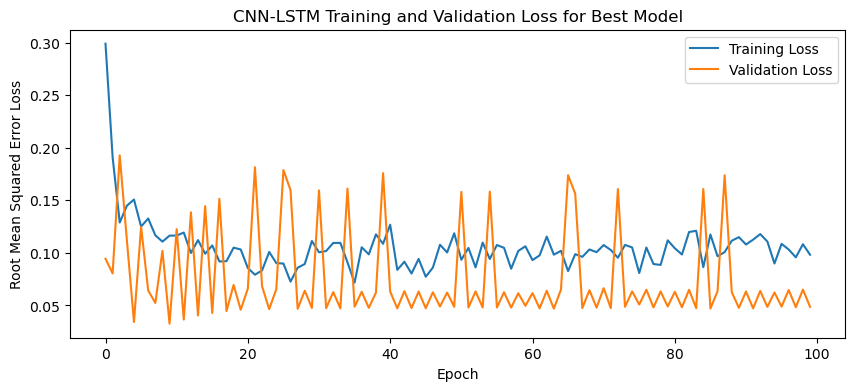

1/1 - 2s - loss: 0.0699 - 2s/epoch - 2s/step
Test Loss: 0.06985060125589371
Fold 2:
Epoch 1/100
19/19 [==============================] - 15s 402ms/step - loss: 0.2796 - val_loss: 0.1391
Epoch 2/100
19/19 [==============================] - 5s 286ms/step - loss: 0.1590 - val_loss: 0.0398
Epoch 3/100
19/19 [==============================] - 7s 356ms/step - loss: 0.1664 - val_loss: 0.3135
Epoch 4/100
19/19 [==============================] - 8s 407ms/step - loss: 0.1422 - val_loss: 0.1734
Epoch 5/100
19/19 [==============================] - 6s 303ms/step - loss: 0.1382 - val_loss: 0.0564
Epoch 6/100
19/19 [==============================] - 4s 234ms/step - loss: 0.1181 - val_loss: 0.0672
Epoch 7/100
19/19 [==============================] - 4s 230ms/step - loss: 0.1055 - val_loss: 0.1195
Epoch 8/100
19/19 [==============================] - 5s 241ms/step - loss: 0.1136 - val_loss: 0.0444
Epoch 9/100
19/19 [==============================] - 5s 271ms/step - loss: 0.1140 - val_loss: 0.1554
Epoch 

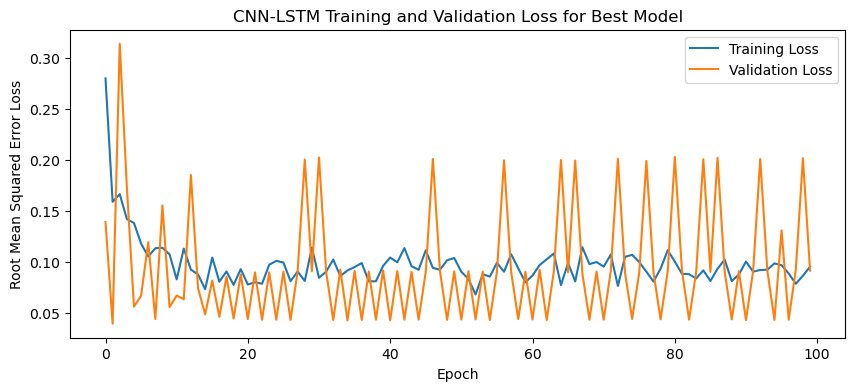

1/1 - 4s - loss: 0.1211 - 4s/epoch - 4s/step
Test Loss: 0.12105982005596161
Fold 3:
Epoch 1/100
19/19 [==============================] - 16s 428ms/step - loss: 0.2932 - val_loss: 0.2078
Epoch 2/100
19/19 [==============================] - 7s 355ms/step - loss: 0.1752 - val_loss: 0.0873
Epoch 3/100
19/19 [==============================] - 6s 303ms/step - loss: 0.1440 - val_loss: 0.0925
Epoch 4/100
19/19 [==============================] - 5s 271ms/step - loss: 0.0883 - val_loss: 0.2167
Epoch 5/100
19/19 [==============================] - 4s 211ms/step - loss: 0.1166 - val_loss: 0.1012
Epoch 6/100
19/19 [==============================] - 5s 246ms/step - loss: 0.1130 - val_loss: 0.2806
Epoch 7/100
19/19 [==============================] - 4s 222ms/step - loss: 0.1228 - val_loss: 0.1572
Epoch 8/100
19/19 [==============================] - 4s 211ms/step - loss: 0.1141 - val_loss: 0.0852
Epoch 9/100
19/19 [==============================] - 4s 224ms/step - loss: 0.1138 - val_loss: 0.1887
Epoch 

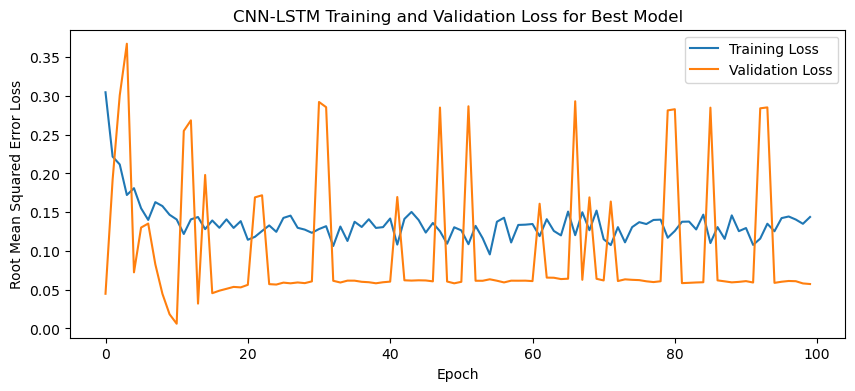

1/1 - 2s - loss: 0.1228 - 2s/epoch - 2s/step
Test Loss: 0.12279481440782547
Fold 5:
Epoch 1/100
19/19 [==============================] - 16s 434ms/step - loss: 0.3079 - val_loss: 0.0630
Epoch 2/100
19/19 [==============================] - 4s 211ms/step - loss: 0.2309 - val_loss: 0.1665
Epoch 3/100
19/19 [==============================] - 4s 230ms/step - loss: 0.1626 - val_loss: 0.2036
Epoch 4/100
19/19 [==============================] - 5s 275ms/step - loss: 0.1797 - val_loss: 0.0717
Epoch 5/100
19/19 [==============================] - 6s 298ms/step - loss: 0.1367 - val_loss: 0.0943
Epoch 6/100
19/19 [==============================] - 5s 280ms/step - loss: 0.1160 - val_loss: 0.2107
Epoch 7/100
19/19 [==============================] - 5s 255ms/step - loss: 0.1217 - val_loss: 0.0570
Epoch 8/100
19/19 [==============================] - 4s 226ms/step - loss: 0.1043 - val_loss: 0.1198
Epoch 9/100
19/19 [==============================] - 5s 281ms/step - loss: 0.1200 - val_loss: 0.0720
Epoch 

In [ ]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

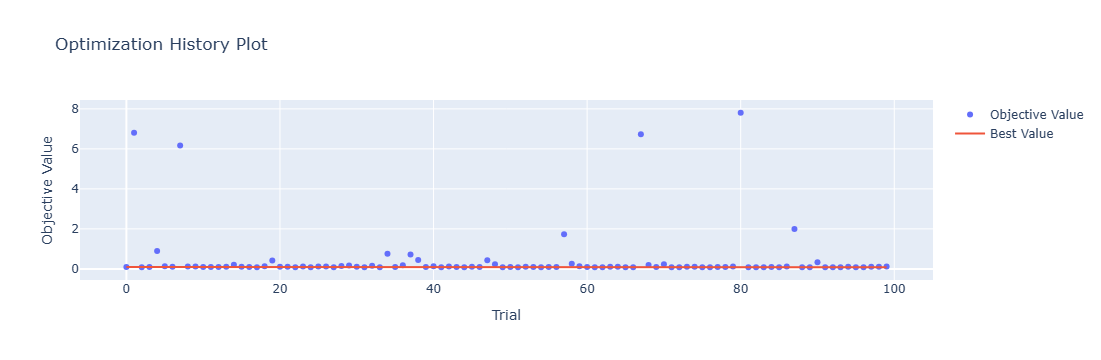

In [10]:
optuna.visualization.plot_optimization_history(study)

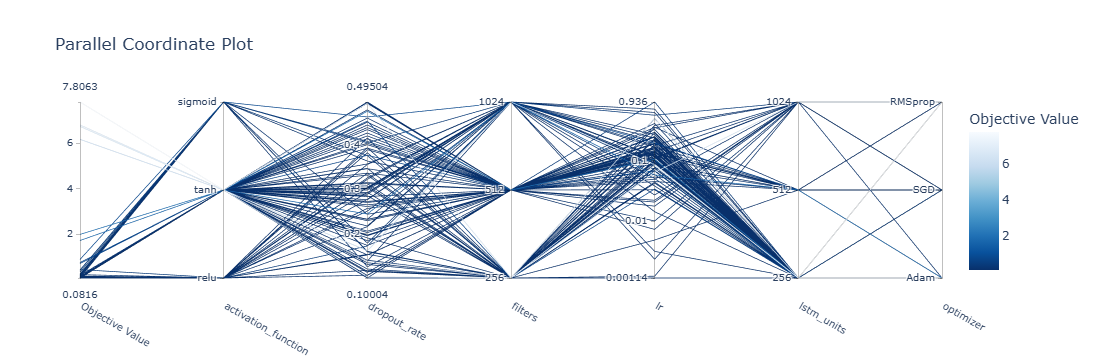

In [11]:
optuna.visualization.plot_parallel_coordinate(study)

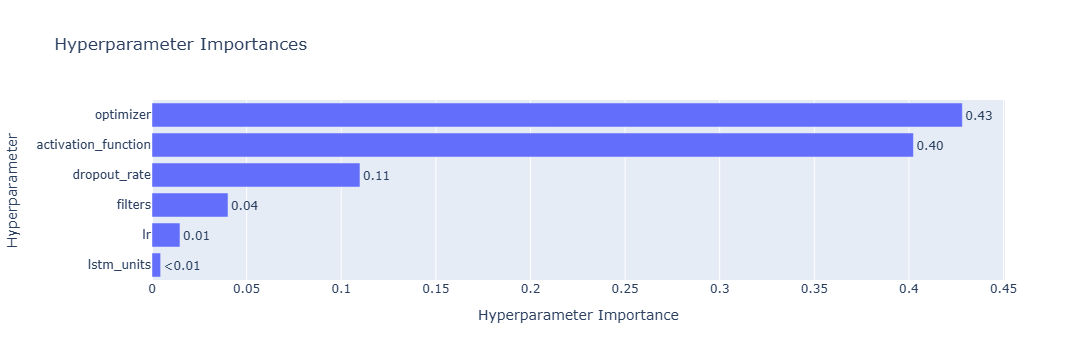

In [12]:
optuna.visualization.plot_param_importances(study)

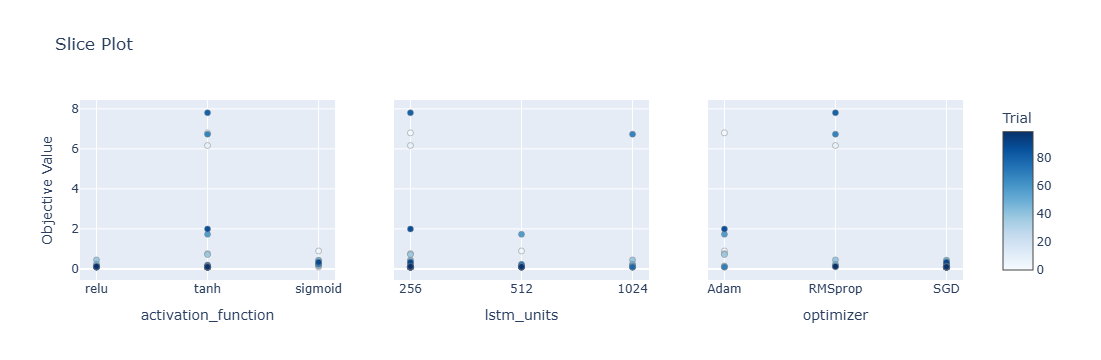

In [13]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

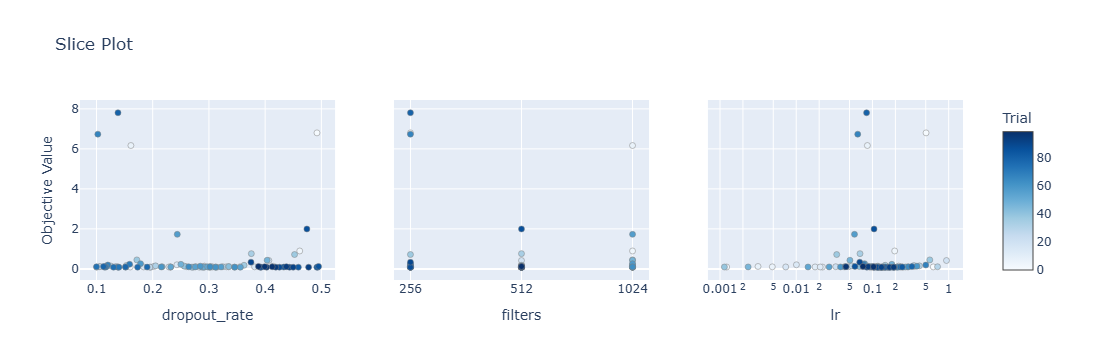

In [16]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 19s 295ms/step - loss: 0.2774 - accuracy: 0.0000e+00 - mae: 0.2774 - rmse: 0.2774 - mape: 59.4474 - pearson: nan - val_loss: 0.0983 - val_accuracy: 0.0000e+00 - val_mae: 0.0983 - val_rmse: 0.0983 - val_mape: 20.4446 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 78ms/step - loss: 0.1799 - accuracy: 0.0000e+00 - mae: 0.1799 - rmse: 0.1799 - mape: 41.6900 - pearson: nan - val_loss: 0.0556 - val_accuracy: 0.0000e+00 - val_mae: 0.0556 - val_rmse: 0.0556 - val_mape: 12.5790 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 80ms/step - loss: 0.1526 - accu

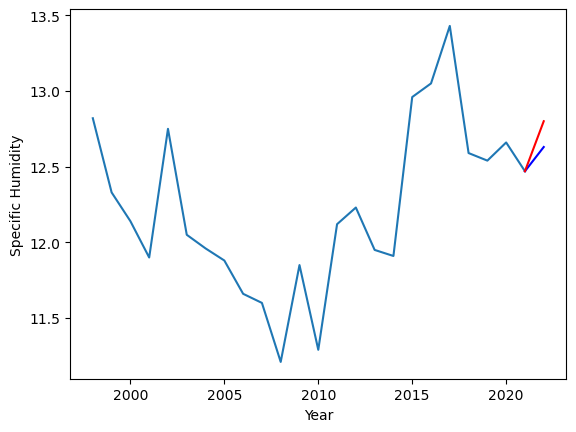

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.63		10.05		0.42


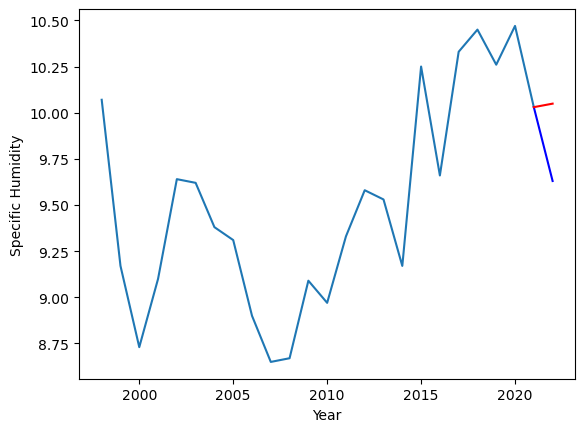

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.63  12.800405
1                1    9.63  10.048995


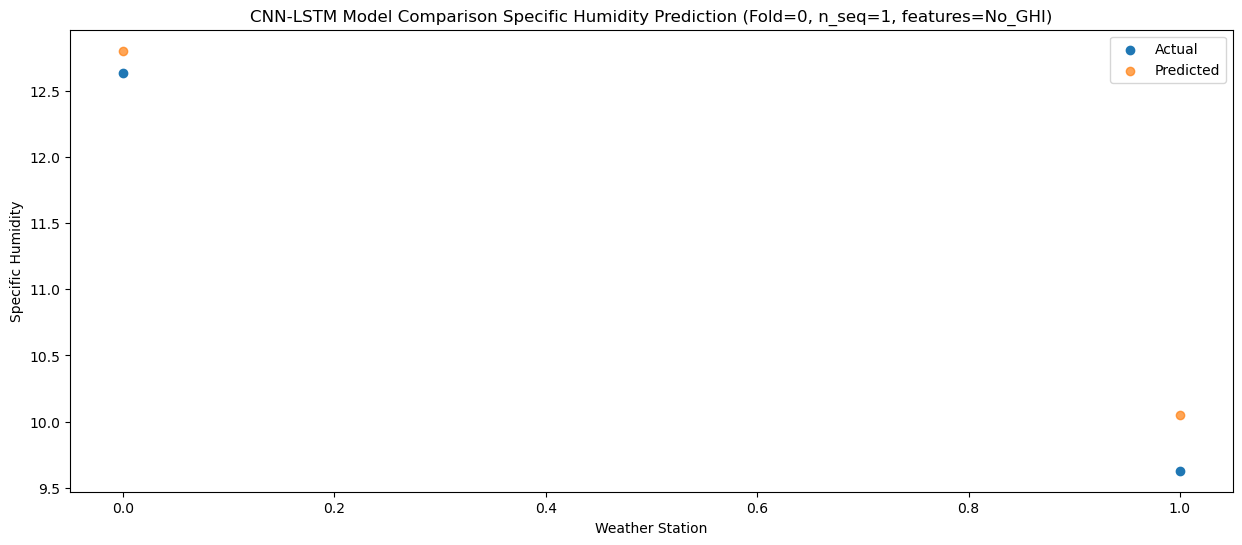

f, t:
[[12.63  9.63]]
[[12.8004051  10.04899538]]
Year at t+1:
t+1 SKRMSE: 0.319840
t+1 KRMSE: 0.319840
t+1 MAE: 0.294700
t+1 SKMAPE: 0.028501
t+1 R2_SCORE: 0.954534
t+1 KMAPE: 0.028501
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.130000
Metrics for this Fold:
SKRMSE: 0.319840
KRMSE: 0.319840
MAE: 0.294700
SKMAPE: 0.028501
R2_SCORE: 0.954534
KMAPE: 0.028501
PEARSON: 1.000000
AVERAGE ACTUAL: 11.130000
Model: "sequential_510"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_510 (Conv1D)         (None, 1, 512)            124416    
                                                                 
 max_pooling1d_510 (MaxPooli  (None, 1, 512)           0         
 ng1D)                                                           
                                                                 
 dropout_1530 (Dropout)      (None, 1, 512)            0         
                                            

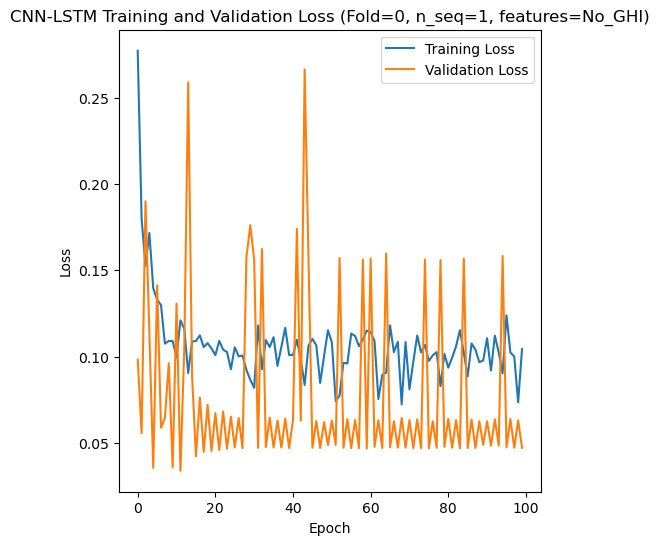

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 33s 485ms/step - loss: 0.2939 - accuracy: 0.0000e+00 - mae: 0.2939 - rmse: 0.2939 - mape: 67.3208 - pearson: nan - val_loss: 0.1593 - val_accuracy: 0.0000e+00 - val_mae: 0.1593 - val_rmse: 0.1593 - val_mape: 30.4408 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 100ms/step - loss: 0.1855 - accuracy: 0.0000e+00 - mae: 0.1855 - rmse: 0.1855 - mape: 42.0884 - pearson: nan - val_loss: 0.0418 - val_accuracy: 0.0000e+00 - val_mae: 0.0418 - val_rmse: 0.0418 - val_mape: 8.3011 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 96ms/step - loss: 0.1639 - accu

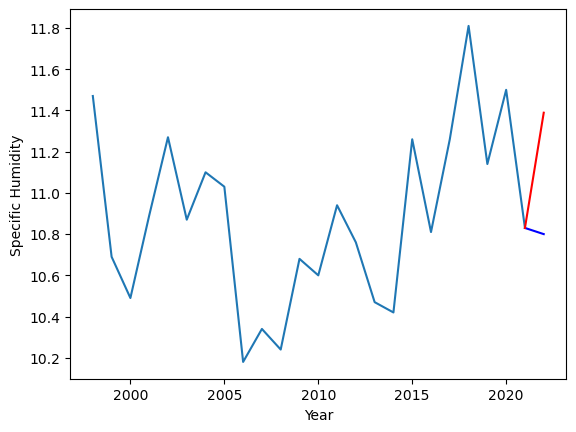

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		7.55		-0.52


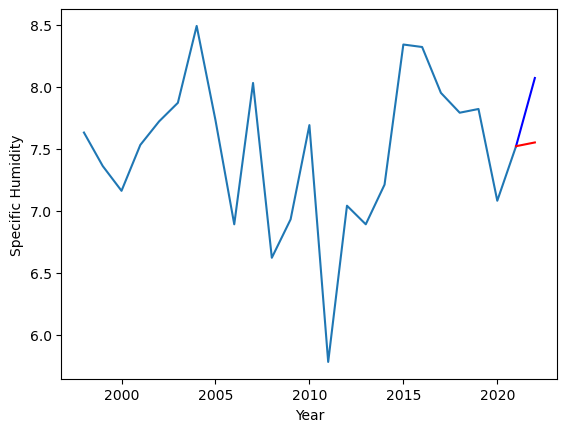

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.388980
1                1    8.07   7.550146


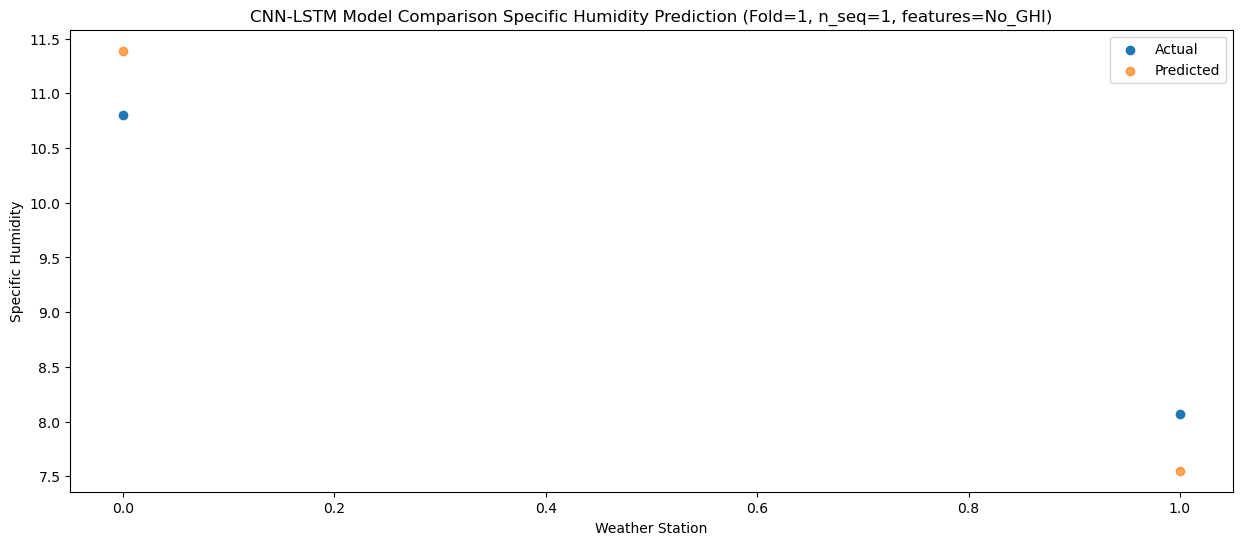

f, t:
[[10.8   8.07]]
[[11.3889795   7.55014553]]
Year at t+1:
t+1 SKRMSE: 0.555493
t+1 KRMSE: 0.555493
t+1 MAE: 0.554417
t+1 SKMAPE: 0.059477
t+1 R2_SCORE: 0.834388
t+1 KMAPE: 0.059477
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.435000
Metrics for this Fold:
SKRMSE: 0.555493
KRMSE: 0.555493
MAE: 0.554417
SKMAPE: 0.059477
R2_SCORE: 0.834388
KMAPE: 0.059477
PEARSON: 1.000000
AVERAGE ACTUAL: 9.435000
Model: "sequential_511"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_511 (Conv1D)         (None, 1, 512)            124416    
                                                                 
 max_pooling1d_511 (MaxPooli  (None, 1, 512)           0         
 ng1D)                                                           
                                                                 
 dropout_1533 (Dropout)      (None, 1, 512)            0         
                                              

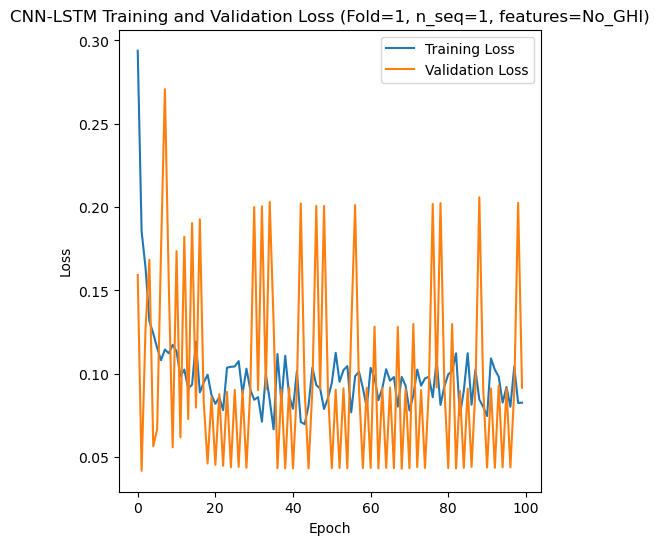

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 41s 610ms/step - loss: 0.2466 - accuracy: 0.0000e+00 - mae: 0.2466 - rmse: 0.2466 - mape: 56.0314 - pearson: nan - val_loss: 0.1766 - val_accuracy: 0.0000e+00 - val_mae: 0.1766 - val_rmse: 0.1766 - val_mape: 30.6206 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 80ms/step - loss: 0.1755 - accuracy: 0.0000e+00 - mae: 0.1755 - rmse: 0.1755 - mape: 38.2284 - pearson: nan - val_loss: 0.0775 - val_accuracy: 0.0000e+00 - val_mae: 0.0775 - val_rmse: 0.0775 - val_mape: 13.9988 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 87ms/step - loss: 0.1236 - accu

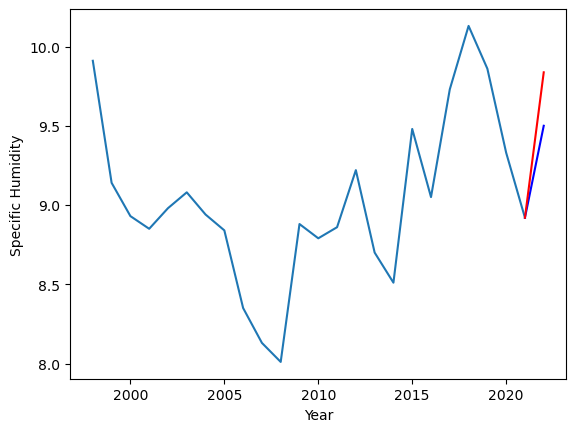

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.56		8.42		-0.14


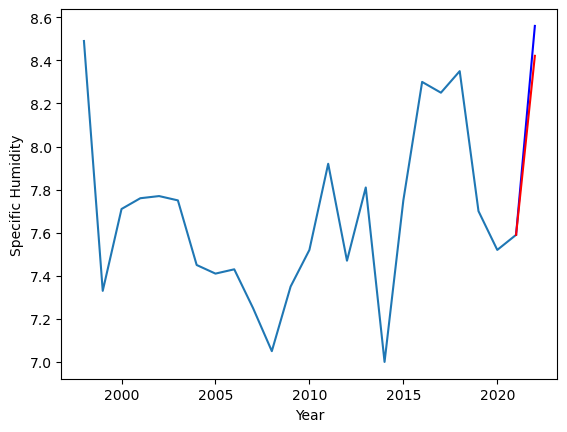

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.50   9.837272
1                1    8.56   8.421104


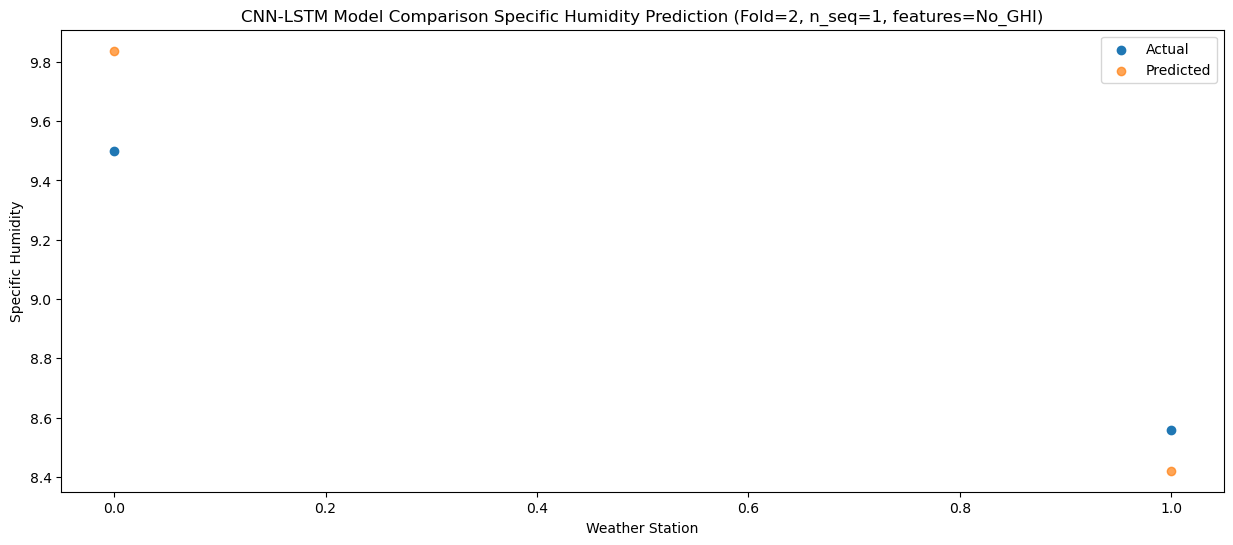

f, t:
[[9.5  8.56]]
[[9.83727174 8.42110426]]
Year at t+1:
t+1 SKRMSE: 0.257919
t+1 KRMSE: 0.257919
t+1 MAE: 0.238084
t+1 SKMAPE: 0.025864
t+1 R2_SCORE: 0.698859
t+1 KMAPE: 0.025864
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.030000
Metrics for this Fold:
SKRMSE: 0.257919
KRMSE: 0.257919
MAE: 0.238084
SKMAPE: 0.025864
R2_SCORE: 0.698859
KMAPE: 0.025864
PEARSON: 1.000000
AVERAGE ACTUAL: 9.030000
Model: "sequential_512"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_512 (Conv1D)         (None, 1, 512)            124416    
                                                                 
 max_pooling1d_512 (MaxPooli  (None, 1, 512)           0         
 ng1D)                                                           
                                                                 
 dropout_1536 (Dropout)      (None, 1, 512)            0         
                                                  

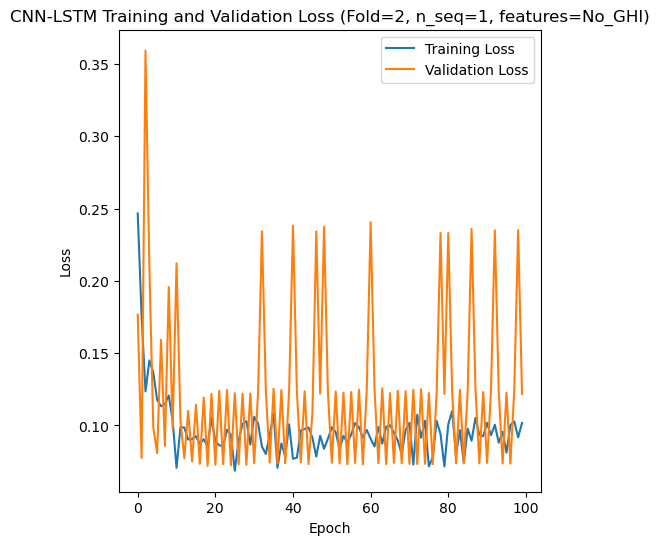

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 21s 556ms/step - loss: 0.2935 - accuracy: 0.0000e+00 - mae: 0.2935 - rmse: 0.2935 - mape: 45.8679 - pearson: nan - val_loss: 0.0034 - val_accuracy: 0.0000e+00 - val_mae: 0.0034 - val_rmse: 0.0034 - val_mape: 0.4925 - val_pearson: nan
Epoch 2/100
20/20 [==============================] - 1s 61ms/step - loss: 0.1965 - accuracy: 0.0000e+00 - mae: 0.1965 - rmse: 0.1965 - mape: 30.2846 - pearson: nan - val_loss: 0.2332 - val_accuracy: 0.0000e+00 - val_mae: 0.2332 - val_rmse: 0.2332 - val_mape: 33.5128 - val_pearson: nan
Epoch 3/100
20/20 [==============================] - 1s 45ms/step - loss: 0.1994 - accuracy: 0.0000e+00 - mae: 0.1994 - rmse: 0.1994 - mape: 32.77

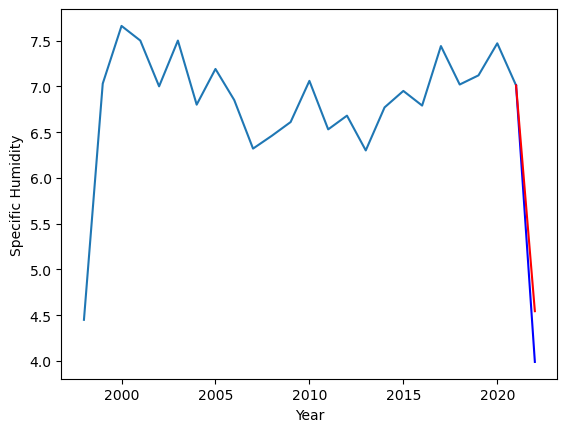

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.30		8.43		0.13


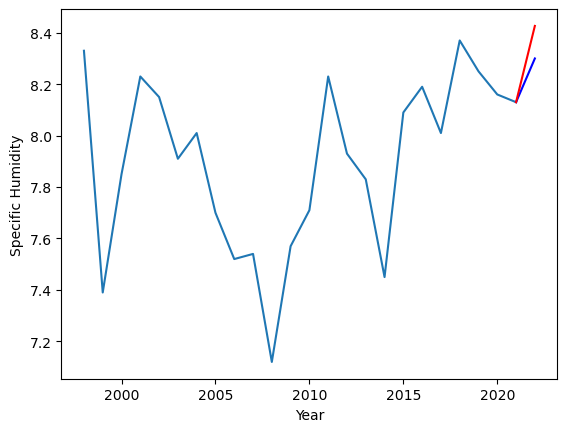

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    3.99   4.544331
1                1    8.30   8.426566


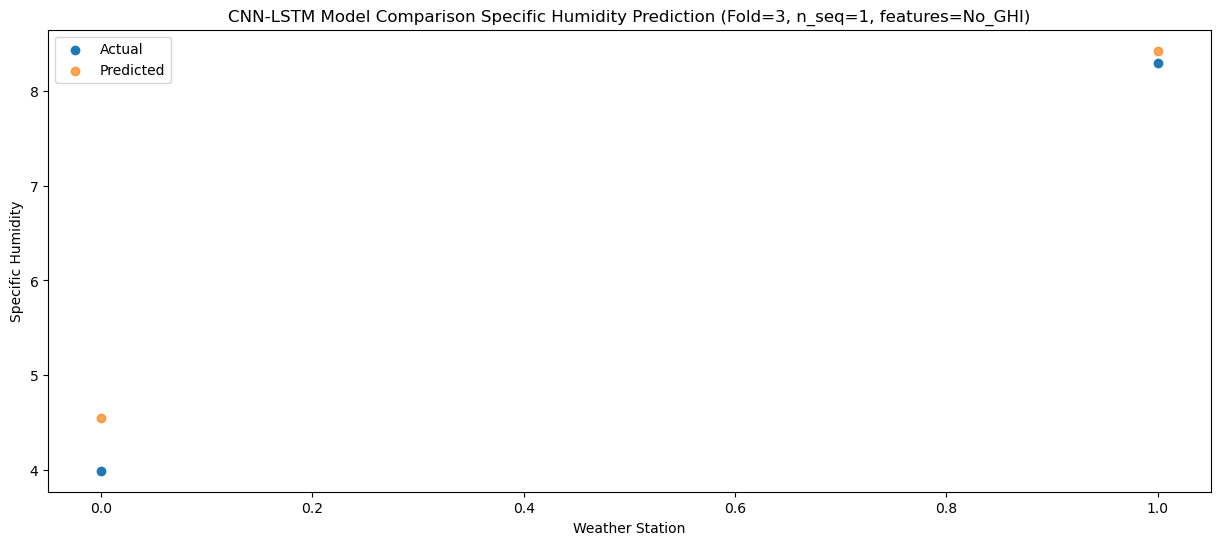

f, t:
[[3.99 8.3 ]]
[[4.54433088 8.42656621]]
Year at t+1:
t+1 SKRMSE: 0.402058
t+1 KRMSE: 0.402058
t+1 MAE: 0.340449
t+1 SKMAPE: 0.077089
t+1 R2_SCORE: 0.965192
t+1 KMAPE: 0.077089
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.145000
Metrics for this Fold:
SKRMSE: 0.402058
KRMSE: 0.402058
MAE: 0.340449
SKMAPE: 0.077089
R2_SCORE: 0.965192
KMAPE: 0.077089
PEARSON: 1.000000
AVERAGE ACTUAL: 6.145000
Model: "sequential_513"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_513 (Conv1D)         (None, 1, 512)            124416    
                                                                 
 max_pooling1d_513 (MaxPooli  (None, 1, 512)           0         
 ng1D)                                                           
                                                                 
 dropout_1539 (Dropout)      (None, 1, 512)            0         
                                                  

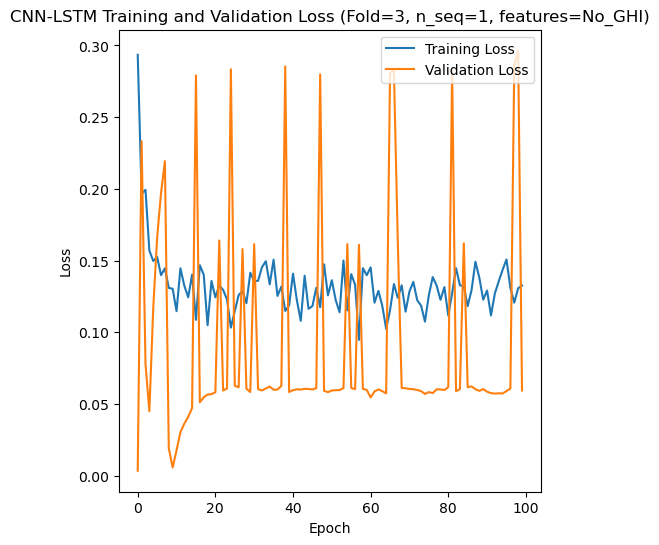

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 12s 95ms/step - loss: 0.3006 - accuracy: 0.0000e+00 - mae: 0.3006 - rmse: 0.3006 - mape: 68.6676 - pearson: nan - val_loss: 0.0685 - val_accuracy: 0.0000e+00 - val_mae: 0.0685 - val_rmse: 0.0685 - val_mape: 15.8309 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2101 - accuracy: 0.0000e+00 - mae: 0.2101 - rmse: 0.2101 - mape: 48.0020 - pearson: nan - val_loss: 0.1093 - val_accuracy: 0.0000e+00 - val_mae: 0.1093 - val_rmse: 0.1093 - val_mape: 28.2031 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1623 - accuracy

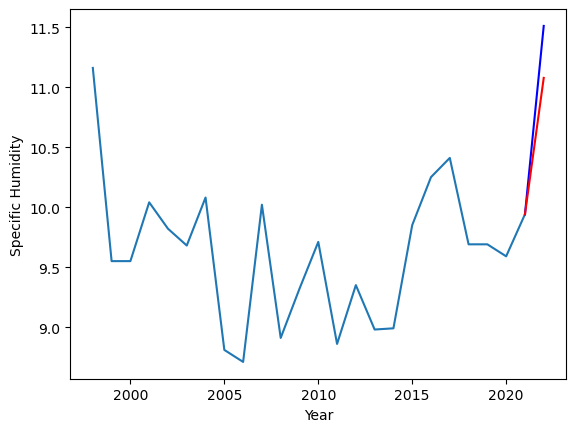

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.66		8.25		-0.41


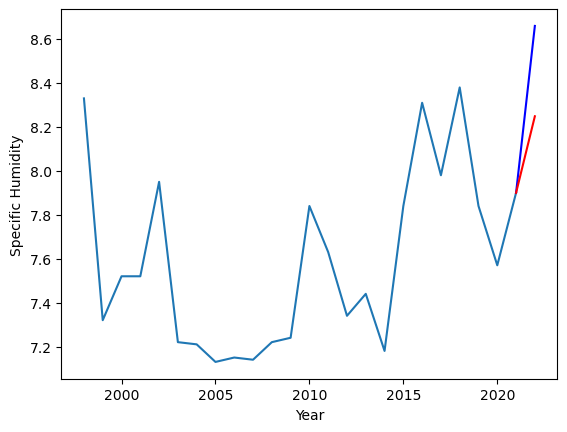

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.51  11.076881
1                1    8.66   8.248582


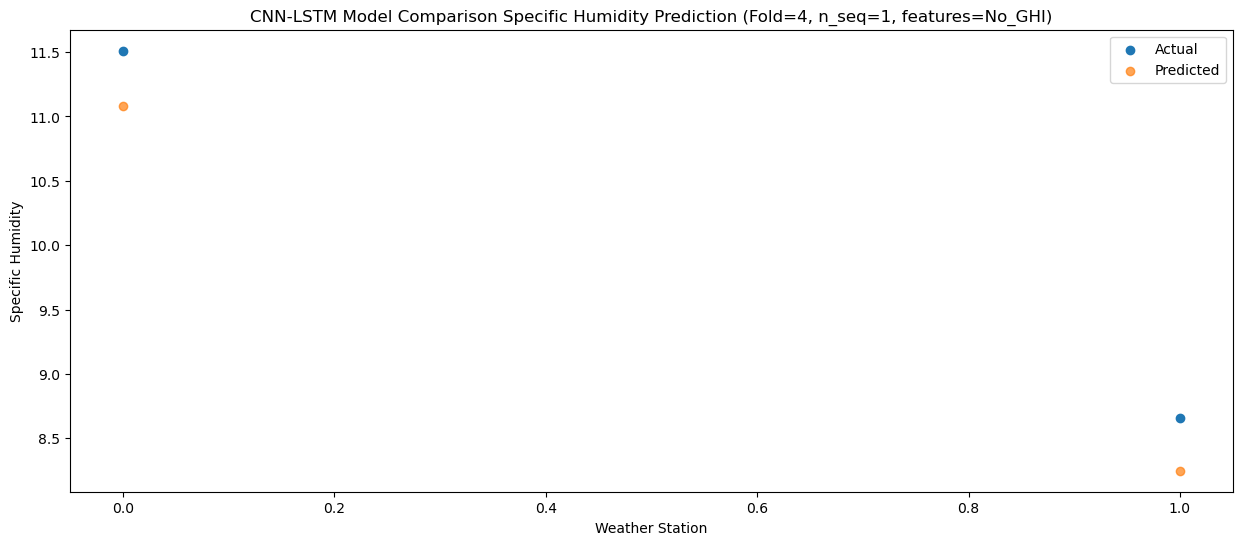

f, t:
[[11.51  8.66]]
[[11.07688111  8.24858212]]
Year at t+1:
t+1 SKRMSE: 0.422408
t+1 KRMSE: 0.422408
t+1 MAE: 0.422268
t+1 SKMAPE: 0.042569
t+1 R2_SCORE: 0.912131
t+1 KMAPE: 0.042569
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 10.085000
Metrics for this Fold:
SKRMSE: 0.422408
KRMSE: 0.422408
MAE: 0.422268
SKMAPE: 0.042569
R2_SCORE: 0.912131
KMAPE: 0.042569
PEARSON: 1.000000
AVERAGE ACTUAL: 10.085000
Model: "sequential_514"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_514 (Conv1D)         (None, 1, 512)            124416    
                                                                 
 max_pooling1d_514 (MaxPooli  (None, 1, 512)           0         
 ng1D)                                                           
                                                                 
 dropout_1542 (Dropout)      (None, 1, 512)            0         
                                            

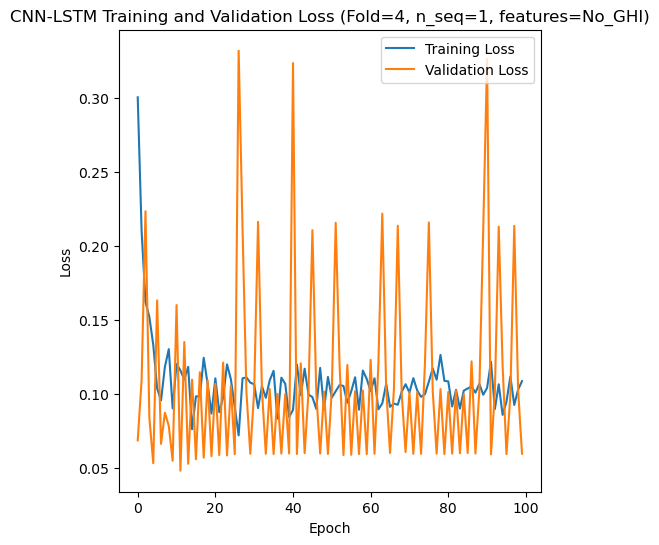

[[0.3198398239476024], [0.5554932622431669], [0.2579188369615597], [0.40205828321382425], [0.4224077700631361]]
[[array(0.31983982)], [array(0.55549326)], [array(0.25791884)], [array(0.40205828)], [array(0.42240777)]]
[[0.29470023844391147], [0.5544169883430006], [0.2380837404727938], [0.3404485423862931], [0.42226838707923875]]
[[0.028500737646027296], [0.059476644777373966], [0.02586421319880455], [0.07708949253246983], [0.0425688146712801]]
[[0.9545344386742963], [0.8343878144627968], [0.6988586398388243], [0.9651916466640796], [0.912131326951204]]
[[array(0.02850074)], [array(0.05947664)], [array(0.02586421)], [array(0.07708949)], [array(0.04256881)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[12.63  9.63 10.8   8.07  9.5   8.56  3.99  8.3  11.51  8.66]
[12.8004051  10.04899538 11.3889795   7.55014553  9.83727174  8.42110426
  4.54433088  8.42656621 11.07688111  8.24858212]
Accuracy Results:
RMSE for each fold:
[[0.3198398239476024], [0.5554932622431669], [0

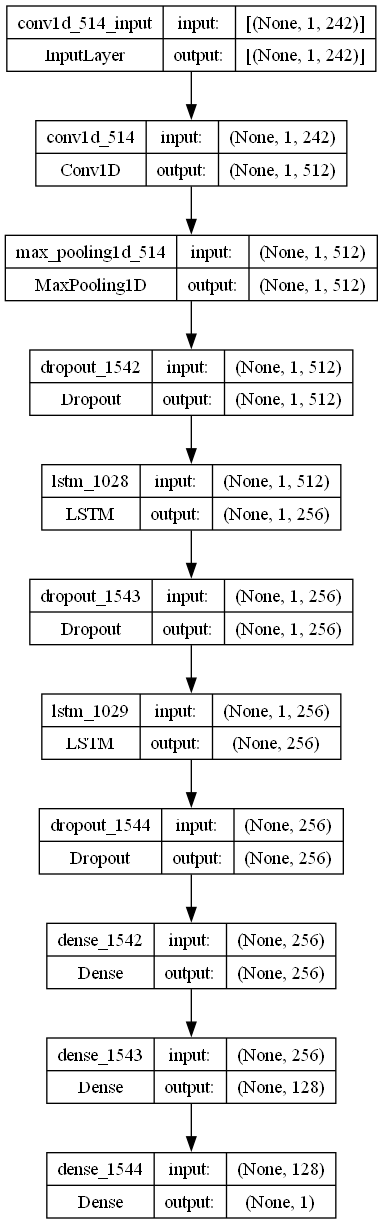

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.10573342960906708
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 256
    dropout_rate = 0.3915321244056659

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S1_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)